# Modeling

## Import data

In [2]:
import pandas as pd

# Read dataframe from the pickle format
wide_df = pd.read_pickle("../../data/processed/preprocessed_df.pkl")

## Select features

In [67]:
#X = wide_df[["sex_gender", "age", "eeg", "engel_outcomes", "mri",
#             "neuroanatomical_labeling", "neuropsychological_testing",
#             "surgical_information"]]

X = wide_df[["sex_gender", "age", "eeg", "engel_outcomes", "mri", "phys_findings", "age_of_onset", "eo_yrs_postsurg",
             "neuroanatomical_labeling", "neuropsychological_testing", "surg_stage", "neuro_findings",
             "surgical_information", "resect_procedure___1", "resect_procedure___2", "resect_procedure___3",
             "resect_procedure___4", "resect_procedure___5", "resect_procedure___6", "resect_procedure___7",
             "resect_procedure___8", "resect_procedure___9", "resect_procedure___10", "resect_procedure___11",
             "resect_procedure___12", "resect_procedure___14", "resect_procedure___15"]]


#X2 = wide_df.drop(["surg_engel", "surg_engel___1", "surg_engel___2", "surg_engel___3",
#                   "surg_engel___4", "engel_class1", "engel_class2", "engel_class3",
#                   "engel_class4",], axis=1)
y = wide_df["surg_engel"]

# Turns the outcome variable from range [1,4] to [0,3]
y = y - 1

## Split data into train/test

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## Scale continuous variables

In [70]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_train.mean(), inplace=True)

column_transformer = ColumnTransformer(
    transformers=[
        ('age', StandardScaler(), ['age']),
        ('age_of_onset', StandardScaler(), ['age_of_onset']),
        ('eo_yrs_postsurg', StandardScaler(), ['eo_yrs_postsurg'])
        # Add more transformers for other columns if needed
    ],
    remainder='passthrough'  # Keep the columns not specified in transformers unchanged
)

X_train_scaled = column_transformer.fit_transform(X_train)
X_test_scaled = column_transformer.transform(X_test)

c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and 

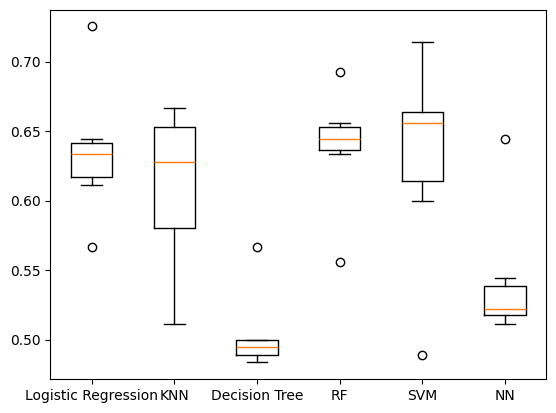

In [71]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

models = {"Logistic Regression": LogisticRegression(max_iter=1000),"KNN": KNeighborsClassifier(),
          "Decision Tree": DecisionTreeClassifier(), "RF": RandomForestClassifier(),
          "SVM": SVC(max_iter=1000), "NN": MLPClassifier(max_iter=1000, random_state=42)}
results = []

for model in models.values():
	kf = KFold(n_splits=6, random_state=42, shuffle=True)
	cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
	results.append(cv_results)

plt.boxplot(results, labels=models.keys())
plt.show()

## Logistic Regression

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create a Logistic Regression classifier
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)

# Train the classifier on the training data
lr.fit(X_train, y_train)

# Make predictions on the test data
y_pred = lr.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.67


c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Decision Tree classifier

In [74]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier(random_state=42)

# Turn outcome variable into dummy variables
y_train_encoded = pd.get_dummies(y_train, columns=["surg_engel"], drop_first=True)
y_test_encoded = pd.get_dummies(y_test, columns=["surg_engel"], drop_first=True)

# Train the classifier on the training data
clf.fit(X_train, y_train_encoded)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.57


## Random Forest

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.66


## Support Vector Machines (SVM)

In [76]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create an SVM classifier
clf = SVC(kernel='linear', C=1, random_state=42)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.67


## Neural Network

In [78]:
import tensorflow as tf

# Create a simple neural network model using Keras
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(set(y_train)), activation='softmax')  # Output layer for multiclass classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training data
model.fit(X_train_scaled, y_train, epochs=15, batch_size=32, validation_split=0.2, verbose=2)

# Make predictions on the test data
y_pred_prob = model.predict(X_test_scaled)
y_pred = tf.argmax(y_pred_prob, axis=1).numpy()

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Epoch 1/15
14/14 - 1s - loss: 1.2114 - accuracy: 0.6227 - val_loss: 1.1033 - val_accuracy: 0.6422 - 1s/epoch - 104ms/step
Epoch 2/15
14/14 - 0s - loss: 1.0893 - accuracy: 0.6227 - val_loss: 1.0730 - val_accuracy: 0.6422 - 72ms/epoch - 5ms/step
Epoch 3/15
14/14 - 0s - loss: 1.0439 - accuracy: 0.6227 - val_loss: 1.0529 - val_accuracy: 0.6422 - 68ms/epoch - 5ms/step
Epoch 4/15
14/14 - 0s - loss: 1.0147 - accuracy: 0.6227 - val_loss: 1.0365 - val_accuracy: 0.6422 - 80ms/epoch - 6ms/step
Epoch 5/15
14/14 - 0s - loss: 0.9906 - accuracy: 0.6227 - val_loss: 1.0326 - val_accuracy: 0.6422 - 69ms/epoch - 5ms/step
Epoch 6/15
14/14 - 0s - loss: 0.9742 - accuracy: 0.6435 - val_loss: 1.0280 - val_accuracy: 0.6514 - 68ms/epoch - 5ms/step
Epoch 7/15
14/14 - 0s - loss: 0.9610 - accuracy: 0.6505 - val_loss: 1.0216 - val_accuracy: 0.6514 - 76ms/epoch - 5ms/step
Epoch 8/15
14/14 - 0s - loss: 0.9441 - accuracy: 0.6528 - val_loss: 1.0176 - val_accuracy: 0.6606 - 71ms/epoch - 5ms/step
Epoch 9/15
14/14 - 0s - 

## Perform PCA

In [79]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Extract numerical features
numerical_features = X2.select_dtypes(include=['float64', 'int64']).copy()

# Impute missing values
imputer = SimpleImputer(strategy='mean')  # You can use other strategies like 'median' or 'most_frequent'
numerical_features_imputed = pd.DataFrame(imputer.fit_transform(numerical_features), columns=numerical_features.columns)

# Data preprocessing (standardization)
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features_imputed)

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(numerical_features_scaled)

# Plot explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio for PCA')
plt.show()

NameError: name 'X2' is not defined

In [75]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

X2 = wide_df.drop(["surg_engel", "surg_engel___1", "surg_engel___2", "surg_engel___3",
                   "surg_engel___4", "engel_class1", "engel_class2", "engel_class3",
                   "engel_class4",], axis=1)
# Extract numerical features
numerical_features = X2.select_dtypes(include=['float64', 'int64']).copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(numerical_features, y, test_size=0.2, random_state=42)

# Impute missing values separately for training and testing sets
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Data preprocessing (standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Perform PCA
pca = PCA(n_components=50)  # Choose the number of components based on your analysis
pca_result_train = pca.fit_transform(X_train_scaled)
pca_result_test = pca.transform(X_test_scaled)

# Create a Random Forest classifier
clf = SVC(kernel='linear', C=1.0, random_state=42)

# Train the classifier on the training data
clf.fit(pca_result_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(pca_result_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.68


## Print system information

In [3]:
import session_info

session_info.show()